# Statistics
- how many generated examples are correct for each category?
- how many correct examples are can fool 0, 1, 2, 3 models?
- can the hypotheses length be a discriminative factor?

In [5]:
import polars as pl
from rich.console import Console
from rich.table import Table
console = Console()
LABEL_NAMES = ["ENTAILMENT", "NEUTRAL", "CONTRADICTION"]
output_name = "data/gpt4o-03.04_and_single_class_prompt.csv"
new_df = pl.read_csv(output_name)
new_df.height

46

### How many synthetic hypotheses respect the targer label?

In [6]:
table = Table(title=output_name.split('/')[-1])

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("Percentage", style="green", justify='center')
table.add_column("Values", justify="right", style="magenta")

for label in LABEL_NAMES:
    num_correct = new_df.filter(pl.col(f'{label} Correct?') == True).height
    support = new_df.filter(pl.col(f'Generated {label} Hypothesis') != '')
    table.add_row(
        f"Synthetic {label:<13} samples that are correct:", 
        f"{100*num_correct/support.height:.2f}%", 
        f"{num_correct}/{support.height}") 

console.print(table)
          

                  gpt4o-03.04_and_single_class_prompt.csv                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃ Category                                          ┃ Percentage ┃ Values ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ Synthetic ENTAILMENT    samples that are correct: │  100.00%   │  27/27 │
│ Synthetic NEUTRAL       samples that are correct: │   96.15%   │  25/26 │
│ Synthetic CONTRADICTION samples that are correct: │  100.00%   │  27/27 │
└───────────────────────────────────────────────────┴────────────┴────────┘

### How many correct examples are can fool 0, 1, 2, 3 models?

In [7]:
table = Table(title=output_name.split('/')[-1])

table.add_column("Category of correct synthetic samples", justify="left", style="cyan", no_wrap=False)
table.add_column("Fool 0 models", style="red", justify='center')
table.add_column("%", style="red", justify='center')
table.add_column("Fool >= 1 models", style="green", justify='center')
table.add_column("%", style="green", justify='center')
table.add_column("Fool >= 2 models", style="green", justify='center')
table.add_column("%", style="green", justify='center')
table.add_column("Fool >= 3 models", style="green", justify='center')
table.add_column("%", style="green", justify='center')
table.add_column("Support", justify="right", style="magenta")

for label in LABEL_NAMES:
    # retrieve correct samples per label
    correct_df = new_df.filter(pl.col(f'{label} Correct?') == True)
    num_correct = correct_df.height

    fool_0 = correct_df.filter(pl.col(f"{label} difficulty score") == 0).height
    fool_at_least_1 = correct_df.filter(pl.col(f"{label} difficulty score") >= 1).height
    fool_at_least_2 = correct_df.filter(pl.col(f"{label} difficulty score") >= 2).height
    fool_at_least_3 = correct_df.filter(pl.col(f"{label} difficulty score") >= 3).height

    table.add_row(
        label, 
        f"{fool_0:>2}",
        f"{100*fool_0/num_correct:.2f}%", 
        f"{fool_at_least_1:>2}",
        f"{100*fool_at_least_1/num_correct:.2f}%", 
        f"{fool_at_least_2:>2}",
        f"{100*fool_at_least_2/num_correct:.2f}%", 
        f"{fool_at_least_3:>2}",
        f"{100*fool_at_least_3/num_correct:.2f}%", 
        f"{num_correct}"
) 

console.print(table)

                                      gpt4o-03.04_and_single_class_prompt.csv                                      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Category of ┃             ┃        ┃            ┃        ┃             ┃        ┃            ┃        ┃         ┃
┃ correct     ┃             ┃        ┃            ┃        ┃             ┃        ┃            ┃        ┃         ┃
┃ synthetic   ┃   Fool 0    ┃        ┃ Fool >= 1  ┃        ┃  Fool >= 2  ┃        ┃ Fool >= 3  ┃        ┃         ┃
┃ samples     ┃   models    ┃   %    ┃   models   ┃   %    ┃   models    ┃   %    ┃   models   ┃   %    ┃ Support ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ENTAILMENT  │     19      │ 70.37% │      8     │ 29.63% │      8      │ 29.63% │      8     │ 29.63% │      27 │
│ NEUTRAL     │     19      │ 76.00% │      6     │ 24.00% │      6      │ 24.00% │      6     │ 24.00% │      25 │
│ CONTRADICT… │     19      │ 70.37% │      8     │ 29.63% │      7      │ 25.93% │      6     │ 22.22% │      27 │
└─────────────┴─────────────┴────────┴────────────┴────────┴─────────────┴────────┴────────────┴────────┴─────────┘

### Export a csv containing only adversarial samples

In [11]:
to_df = {
    "cid" : [],
    "premise": [],
    "original hypothesis": [],
    "original label": [],
    "generated hypothesis": [],
    "prompted label": [],
    "models fooled": [],
}

for label in LABEL_NAMES:
    # retrieve correct samples per label
    correct_df = new_df.filter(pl.col(f'{label} Correct?') == True)
    num_correct = correct_df.height

    adversarial_samples = correct_df.filter(pl.col(f"{label} difficulty score") >= 1)
    for row in adversarial_samples.iter_rows(named=True):
        to_df['cid'].append(row['cid'])
        to_df['premise'].append(row['premise'])
        to_df["original hypothesis"].append(row['hypothesis'])
        to_df["original label"].append(row['label'])
        to_df["generated hypothesis"].append(row[f'Generated {label} Hypothesis'])
        to_df["prompted label"].append(label)
        to_df["models fooled"].append(row[f'{label} difficulty score'])
        
to_df = pl.DataFrame(to_df).write_csv(output_name.replace('.csv', 'ADV_SAMPLES.csv'))

### Stats on the token lenghts between original and correct generated hypothesis

In [12]:
from numpy import mean

original_hypotheses_len = [] 
generated_hypotheses_len = [] 
adv_generated_hypothesis_len = {0:[], 1:[], 2:[], 3:[]}

for label in LABEL_NAMES:
    samples = new_df.filter(
        (pl.col(f'{label} Correct?') == True) & (pl.col(f'Generated {label} Hypothesis') != '')
    )
    for row in samples.iter_rows(named=True):
        original_hypotheses_len.append(len(row['hypothesis'].strip().split(' ')))
        diff_score = row[f'{label} difficulty score']     
        adv_generated_hypothesis_len[diff_score].append(len(row[f'Generated {label} Hypothesis'].strip().split(' ')))

print(f"> original hypotheses mean length: {mean(original_hypotheses_len):.2f}")

for k in range(0,3):
    for i in adv_generated_hypothesis_len[k]:
        generated_hypotheses_len.append(i)

print(f"> generated hypotheses mean length: {mean(generated_hypotheses_len):.2f}\t({mean(generated_hypotheses_len)/mean(original_hypotheses_len):.2f}x original)")

> original hypotheses mean length: 8.10
> generated hypotheses mean length: 20.02	(2.47x original)


In [56]:
import numpy as np
import matplotlib.pyplot as plt 

label2color={
    'ENTAILMENT':   'tab:green',
    'NEUTRAL':      'tab:blue',
    'CONTRADICTION':'tab:red'
    }

def grouped_bar_plot(species, means, label2color, ylabel='', title=''):
    x = np.arange(len(species))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor='black', color=label2color[attribute.upper()])
        ax.bar_label(rects, padding=3, fmt=f'%.1f')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=1)

Support:
	 original  - ENTAILMENT     15
	 original  - NEUTRAL        11
	 original  - CONTRADICTION  20
	 synthetic - ENTAILMENT     27
	 synthetic - NEUTRAL        25
	 synthetic - CONTRADICTION  27


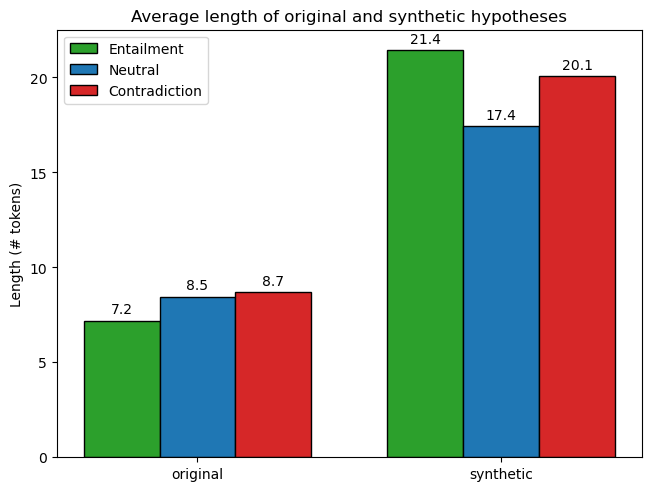

In [62]:
original_h = {}
for label in LABEL_NAMES:
    if label not in original_h.keys():
        original_h[label] = []
    samples = new_df.filter((pl.col('label') == label))
    for row in samples.iter_rows(named=True):
        original_h[label].append(len(row['hypothesis'].strip().split(' ')))

synthetic_h = {}
for label in LABEL_NAMES:
    if label not in synthetic_h.keys():
        synthetic_h[label] = []
    
    samples = new_df.filter(
        (pl.col(f'{label} Correct?') == True) & (pl.col(f'Generated {label} Hypothesis') != '')
    )
    for row in samples.iter_rows(named=True):
        diff_score = row[f'{label} difficulty score']     
        synthetic_h[label].append(len(row[f'Generated {label} Hypothesis'].strip().split(' ')))


species = (
    'original',
    'synthetic'
)

means = {
    'Entailment' : [
        mean(original_h['ENTAILMENT']), 
        mean(synthetic_h['ENTAILMENT'])
        ],
    'Neutral' : [
        mean(original_h['NEUTRAL']),
        mean(synthetic_h['NEUTRAL'])
        ],
    'Contradiction' : [
        mean(original_h['CONTRADICTION']),
        mean(synthetic_h['CONTRADICTION'])]
    }

grouped_bar_plot(
    species, 
    means, 
    label2color, 
    ylabel='Length (# tokens)', 
    title='Average length of original and synthetic hypotheses'
)
print("Support:")
print("\t original  - ENTAILMENT    ", len(original_h['ENTAILMENT']))
print("\t original  - NEUTRAL       ", len(original_h['NEUTRAL']))
print("\t original  - CONTRADICTION ", len(original_h['CONTRADICTION']))
print("\t synthetic - ENTAILMENT    ", len(synthetic_h['ENTAILMENT']))
print("\t synthetic - NEUTRAL       ", len(synthetic_h['NEUTRAL']))
print("\t synthetic - CONTRADICTION ", len(synthetic_h['CONTRADICTION']))

Support:
	 fools 0 - ENTAILMENT     19
	 fools 0 - NEUTRAL        19
	 fools 0 - CONTRADICTION  19
	 -------
	 fools 1 - ENTAILMENT     0
	 fools 1 - NEUTRAL        0
	 fools 1 - CONTRADICTION  1
	 -------
	 fools 2 - ENTAILMENT     0
	 fools 2 - NEUTRAL        0
	 fools 2 - CONTRADICTION  1
	 -------
	 fools 3 - ENTAILMENT     8
	 fools 3 - NEUTRAL        6
	 fools 3 - CONTRADICTION  6


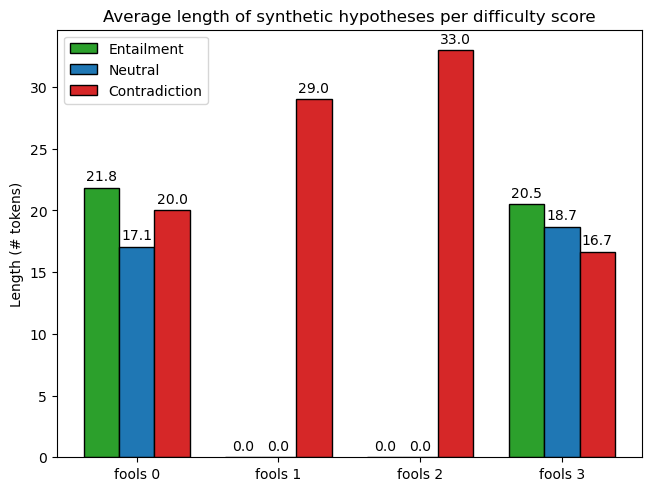

In [63]:
synthetic_h = {}
for label in LABEL_NAMES:
    if label not in synthetic_h.keys():
        synthetic_h[label] = {
            0: [], 1: [], 2: [], 3:[],
        }
    
    samples = new_df.filter(
        (pl.col(f'{label} Correct?') == True) & (pl.col(f'Generated {label} Hypothesis') != '')
    )
    for row in samples.iter_rows(named=True):
        diff_score = row[f'{label} difficulty score']     
        synthetic_h[label][diff_score].append(len(row[f'Generated {label} Hypothesis'].strip().split(' ')))


grouping = (
    'fools 0',
    'fools 1',
    'fools 2',
    'fools 3',
)

data_to_plot = {
    'Entailment' : (
        mean(synthetic_h['ENTAILMENT'][0]) if len(synthetic_h['ENTAILMENT'][0]) > 0 else 0,
        mean(synthetic_h['ENTAILMENT'][1]) if len(synthetic_h['ENTAILMENT'][1]) > 0 else 0,
        mean(synthetic_h['ENTAILMENT'][2]) if len(synthetic_h['ENTAILMENT'][2]) > 0 else 0,
        mean(synthetic_h['ENTAILMENT'][3]) if len(synthetic_h['ENTAILMENT'][3]) > 0 else 0,
    ),
    'Neutral' : (
        mean(synthetic_h['NEUTRAL'][0]) if len(synthetic_h['NEUTRAL'][0]) > 0 else 0,
        mean(synthetic_h['NEUTRAL'][1]) if len(synthetic_h['NEUTRAL'][1]) > 0 else 0,
        mean(synthetic_h['NEUTRAL'][2]) if len(synthetic_h['NEUTRAL'][2]) > 0 else 0,
        mean(synthetic_h['NEUTRAL'][3]) if len(synthetic_h['NEUTRAL'][3]) > 0 else 0,
    ),
    'Contradiction' : (
        mean(synthetic_h['CONTRADICTION'][0]) if len(synthetic_h['CONTRADICTION'][0]) > 0 else 0,
        mean(synthetic_h['CONTRADICTION'][1]) if len(synthetic_h['CONTRADICTION'][1]) > 0 else 0,
        mean(synthetic_h['CONTRADICTION'][2]) if len(synthetic_h['CONTRADICTION'][2]) > 0 else 0,
        mean(synthetic_h['CONTRADICTION'][3]) if len(synthetic_h['CONTRADICTION'][3]) > 0 else 0,
    )
    }

grouped_bar_plot(
    grouping,
    data_to_plot,
    label2color,
    ylabel='Length (# tokens)',
    title='Average length of synthetic hypotheses per difficulty score'
)
print("Support:")
print("\t fools 0 - ENTAILMENT    ", len(synthetic_h['ENTAILMENT'][0]))
print("\t fools 0 - NEUTRAL       ", len(synthetic_h['NEUTRAL'][0]))
print("\t fools 0 - CONTRADICTION ", len(synthetic_h['CONTRADICTION'][0]))
print("\t -------")
print("\t fools 1 - ENTAILMENT    ", len(synthetic_h['ENTAILMENT'][1]))
print("\t fools 1 - NEUTRAL       ", len(synthetic_h['NEUTRAL'][1]))
print("\t fools 1 - CONTRADICTION ", len(synthetic_h['CONTRADICTION'][1]))
print("\t -------")
print("\t fools 2 - ENTAILMENT    ", len(synthetic_h['ENTAILMENT'][2]))
print("\t fools 2 - NEUTRAL       ", len(synthetic_h['NEUTRAL'][2]))
print("\t fools 2 - CONTRADICTION ", len(synthetic_h['CONTRADICTION'][2]))
print("\t -------")
print("\t fools 3 - ENTAILMENT    ", len(synthetic_h['ENTAILMENT'][3]))
print("\t fools 3 - NEUTRAL       ", len(synthetic_h['NEUTRAL'][3]))
print("\t fools 3 - CONTRADICTION ", len(synthetic_h['CONTRADICTION'][3]))